In [1]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split

# Models
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import layers
from keras.models import Sequential

# Training
from sklearn.feature_extraction.text import CountVectorizer
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


2023-12-01 14:03:19.012013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

df = pd.read_csv('source_folder/fake_news_cleaned.csv')

In [4]:
df.head()

,Unnamed: 0.1,Unnamed: 0,title,text,label
0,0,0,‘Maury’ Show Official Facebook Posts F*CKED U...,Maury is perhaps one of the trashiest shows on...,0
1,1,1,Trump’s Favorite News Channel Tries To Soothe...,"Yesterday, after the father of one of the UCLA...",0
2,2,2,"Russia warns Iraq, Kurds not to destabilize Mi...",MOSCOW (Reuters) - Russia on Wednesday warned ...,1
3,3,3,WATCH STEVE SCALISE Throw A Strike At The Nati...,"House Majority Whip Steve Scalise (R., La.) th...",0
4,4,4,Trump Will HATE What Stephen Colbert Just Did...,It can be said that Late Show host Stephen Col...,0


In [5]:
# define a function that allows us to evaluate our models

# def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    # training
  #  y_predict_train = predict_fun(X_train)
   # train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing
    #y_predict_test = predict_fun(X_test)
    #test_acc = accuracy_score(y_test,y_predict_test)
    
    #return train_acc, test_acc

def predict_func(X):
    return model.predict(X)

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    # training
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train, y_predict_train)
    
    # testing
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test, y_predict_test)
    
    # confusion matrix
    confusion_mat = confusion_matrix(y_train, y_predict_train)
    
    return train_acc, test_acc, confusion_mat

In [6]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange: 
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term
    
    return lb, ub

In [7]:
# read in our data and preprocess it
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [8]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 24353 texts.


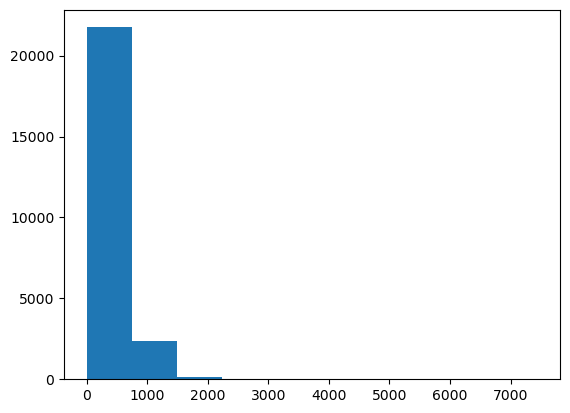

In [9]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

In [10]:
# set up vector models for training and testing

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word", 
                             binary = True, 
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names_out())

In [11]:
# create training and test data

docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [12]:
# Naive Bayes Model

model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB()

Training Accuracy: 95.36%
Testing Accuracy: 93.76%
Training Confusion Matrix
[[ 8501   432]
 [  472 10077]]


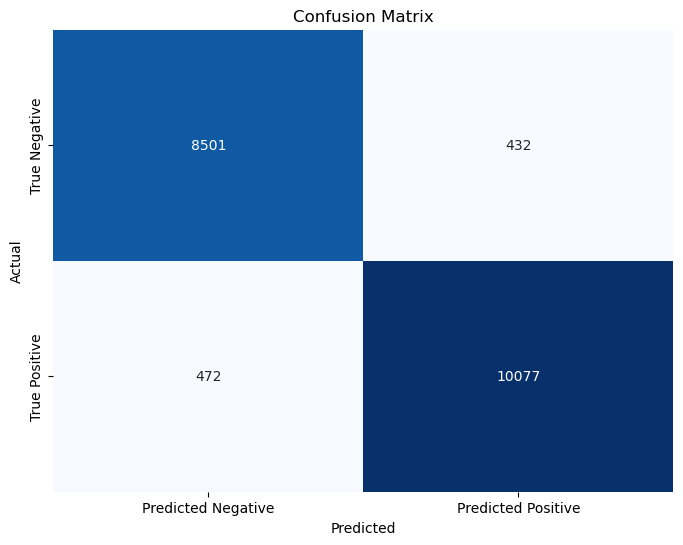

In [15]:
# evaluate model
train_acc, test_acc, confusion_mat = evaluate_model(predict_func, docterm_train, y_train, docterm_test, y_test)

print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Training Confusion Matrix")
print(confusion_mat)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Predicted Negative', 'Predicted Positive'],
           yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [16]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 93.08%-94.44%


In [17]:
# vectorize the text samples into a 2D integer tensor 

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences, 
                     #maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 118475 unique tokens.
Shape of data tensor: (24353, 5000)
Shape of label tensor: (24353,)


In [18]:
# split the data into a training set and a validation set   

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels.apply(lambda x: 0 if x == 0 else 1), 
                                                  test_size=TEST_SPLIT)

In [19]:
# build a 1D convnet with global maxpooling                                                                      

# model = Sequential(
    [
        # part 1: word and sequence processing
#        layers.Embedding(num_words,
 #                        EMBEDDING_DIM, 
  #                       input_length=MAX_SEQUENCE_LENGTH,
   #                      trainable=True),
    #    layers.Conv1D(128, 5, activation='relu'),
     #   layers.GlobalMaxPooling1D(),
        
        # part 2: classification
      #  layers.Dense(128, activation='relu'),
       # layers.Dense(1, activation='sigmoid')
   # ])

#model.compile(loss='binary_crossentropy',
 #             optimizer='rmsprop',
  #            metrics=['accuracy'])

#model.summary()

# Define input layer
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Embedding layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM, 
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)(inputs)

# Convolutional layer
conv1d_layer = Conv1D(128, 5, activation='relu')(embedding_layer)

# Global max pooling layer
global_maxpool_layer = GlobalMaxPooling1D()(conv1d_layer)

# Dense layers for classification
dense_layer1 = Dense(128, activation='relu')(global_maxpool_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer1)

# Create the model
model = Model(inputs=inputs, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()
        

2023-12-01 14:30:57.873061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 300)         7500300   
                                                                 
 conv1d (Conv1D)             (None, 4996, 128)         192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 7,709,069
Trainable params: 7,709,069
Non-trainable params: 0
______________________________________________

In [20]:
# train the model

history = model.fit(x_train, 
                    y_train,
                    batch_size=128,
                    epochs=1,
                    validation_data=(x_val, y_val))

153/153 [==============================] - 1174s 8s/step - loss: 0.0979 - accuracy: 0.9616 - val_loss: 0.0347 - val_accuracy: 0.9860


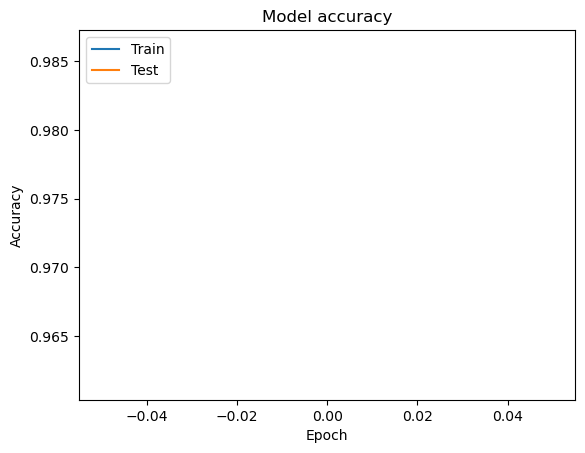

In [21]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

153/153 [==============================] - 74s 485ms/step
Training Accuracy: 99.46%
Testing Accuracy: 98.60%


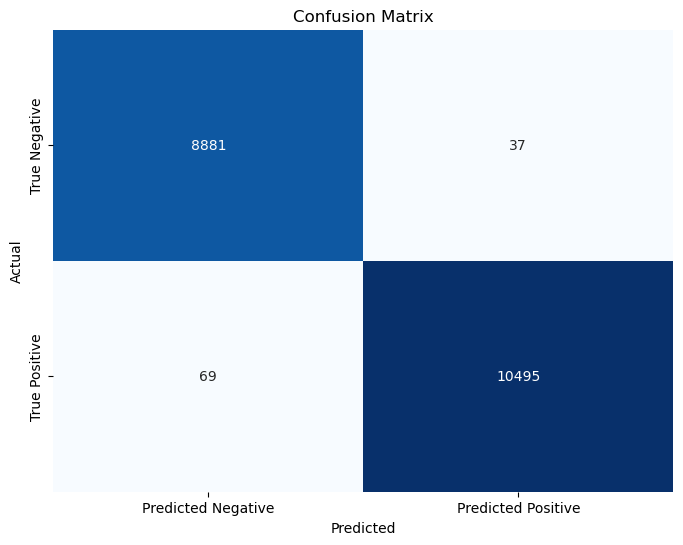

In [22]:
train_acc, test_acc, confusion_mat = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train, 
                                     y_train, 
                                     x_val, 
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Predicted Negative', 'Predicted Positive'],
           yticklabels=['True Negative', 'True Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()